In [1]:
import pandas as pd
import numpy as np
import re #(regular expression - a library useful for searching word in a paragraph)
import nltk
from nltk.corpus import stopwords # stopword- words that doesn't add much value of the paragraph , like -'the' ,'with' ,'i',etc.
from nltk.stem import WordNetLemmatizer # returns the root of a word by removing its prefix and suffix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # to convert text into feature vector (i.e numbers)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from newspaper import Article
import pickle

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kraj5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kraj5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# printing the stopwords of English language
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

.........DATA PREPROCESSING.........

In [4]:
#Loading training dataset to pandas framework
news_dataset = pd.read_csv('./dataset/train.csv')

In [5]:
# size of dataset
news_dataset.shape

(6335, 4)

In [6]:
# printing the first 5 rows of the dataframe
news_dataset.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [18]:
# to check for missing values in the "news_dataset" 
news_dataset.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [19]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

<Axes: xlabel='label', ylabel='count'>

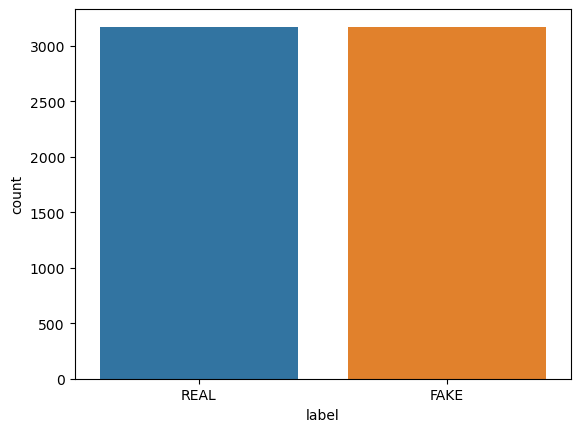

In [20]:
sns.countplot(data=news_dataset,
              x='label',
              order=news_dataset['label'].value_counts().index)

In [28]:
news_dataset.label[news_dataset.label == 'REAL'] = 1
news_dataset.label[news_dataset.label == 'FAKE'] = 0

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\3360778484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset.label[news_dataset.label == 'REAL'] = 1
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\3360778484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset.label[news_dataset.label == 'FAKE'] = 0


In [29]:
# Merging 'title' and 'author' column in a new column 'body'
news_dataset['body']=news_dataset['text']+' '+news_dataset['title']

In [30]:
print(news_dataset['body'])

0       Daniel Greenfield, a Shillman Journalism Fello...
1       Google Pinterest Digg Linkedin Reddit Stumbleu...
2       U.S. Secretary of State John F. Kerry said Mon...
3       — Kaydee King (@KaydeeKing) November 9, 2016 T...
4       It's primary day in New York and front-runners...
                              ...                        
6330    The State Department told the Republican Natio...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332     Anti-Trump Protesters Are Tools of the Oligar...
6333    ADDIS ABABA, Ethiopia —President Obama convene...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: body, Length: 6335, dtype: object


In [31]:
# using NLTK
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [32]:
for x in range(len(news_dataset)) :
    corpus = []
    review = news_dataset['body'][x]
    review = re.sub(r'https?://\S+|www\.\S+', '', review)  # Remove URLs
    review = re.sub(r'\W', ' ', review)  # Remove special characters
    review = re.sub(r'\n', ' ', review)  # Replace newline characters with a space
    review = re.sub(r'\w*\d\w*', '', review)  # Remove words containing digits
    review = review.lower()  # Convert to lowercase
    review = nltk.word_tokenize(review)  # Tokenize
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    news_dataset['body'][x] = review  

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
C:\Users\kraj5\AppData\Local\Temp\ipykernel_19360\2132954961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = revie

In [33]:
# Seperating the data and label
X =news_dataset['body'].values
Y =news_dataset['label'].astype('int').values

In [34]:
print(X)
print(Y)

['daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party go war fbi exactly hillary people done coma patient waking watching hour cnn hospital bed would assume fbi director james comey hillary opponent election fbi attack everyone obama cnn hillary people circulated letter attacking comey currently medium hit piece lambasting targeting trump surprising clinton ally start running attack ad fbi fbi leadership warned entire left wing establishment form lynch mob continue going hillary fbi credibility attacked medium democrat preemptively head result investigation clinton foundation hillary clinton covert struggle fbi agent obama doj people gone explosively public new york time compared comey j edgar hoover bizarre headline james comey role recall hoover fbi fairly practically a

In [35]:
# Splitting the dataset to training and test data 
# 20% of the data will be used for testing, and the remaining 80% will be used for training
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [36]:
# Converting the textual data to numerical data using TfidfVectorizer
vectorizer =TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

In [37]:
# X after numerical vectorization
print(tfidf_X_train)

  (0, 14720)	0.04136003093366593
  (0, 11328)	0.041323435194270085
  (0, 21344)	0.048061528355811574
  (0, 45483)	0.021400089101501044
  (0, 50658)	0.03954319467856228
  (0, 6139)	0.04200202961249525
  (0, 18948)	0.04143359861252122
  (0, 36241)	0.038709692179352106
  (0, 24959)	0.028228601871864687
  (0, 27913)	0.029070351413898066
  (0, 26672)	0.053802047462594725
  (0, 41152)	0.022920416177755667
  (0, 15462)	0.03353687435879221
  (0, 7430)	0.025803822977847578
  (0, 37555)	0.027671193912940695
  (0, 14606)	0.06329912337839162
  (0, 37543)	0.038178827458904725
  (0, 27261)	0.07398556599733068
  (0, 36133)	0.054038119363739784
  (0, 43119)	0.03208274675049812
  (0, 13633)	0.05857367741347884
  (0, 25898)	0.06387985070383233
  (0, 26057)	0.02091394474585102
  (0, 11960)	0.049762941775752766
  (0, 5976)	0.036847306655749985
  :	:
  (5067, 3119)	0.07740941069494567
  (5067, 3877)	0.07968642497334419
  (5067, 35475)	0.08716614988470343
  (5067, 46696)	0.05739263355255321
  (5067, 49592)	

Model Training : Decision Tree Classifier

In [38]:
decision_model = DecisionTreeClassifier()
#training the model
decision_model.fit(tfidf_X_train,Y_train)
# decision_model will be trained and ready to make predictions on new text data

DecisionTreeClassifier()

Evaluation and Prediction

In [39]:
# Predict testing data
Y_test_pred = decision_model.predict(tfidf_X_test)
# accuracy score of test data
test_accuracy = accuracy_score(Y_test_pred,Y_test)

In [40]:
# predicted labels for the testing data
print(Y_test_pred)

[1 0 1 ... 1 1 1]


In [41]:
#  accuracy score of the model on the testing data
print('Accuracy score of test data :',test_accuracy)

Accuracy score of test data : 0.8066298342541437


model correctly predicted approximately 80.66% of the labels in the testing dataset

The confusion matrix for Decision Tree Classifier can be implemented with the code below.

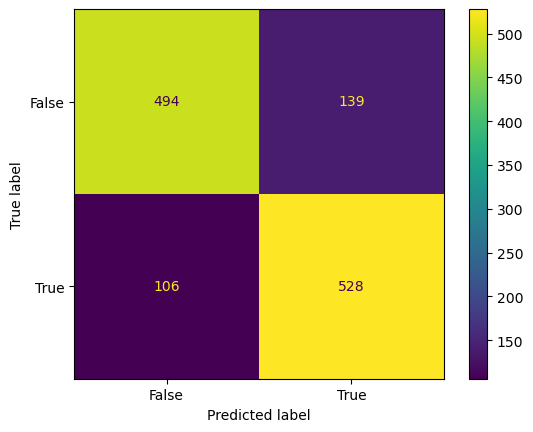

In [43]:
# Confusion matrix of Results from Decision Tree classification
cm = metrics.confusion_matrix(Y_test, Y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

Model Training : Passive Aggressive Classifier

In [44]:
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(tfidf_X_train,Y_train)
# PassiveAggressiveClassifier will be trained and ready to make predictions on new text data

PassiveAggressiveClassifier()

Evaluation and Prediction

In [45]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.61%


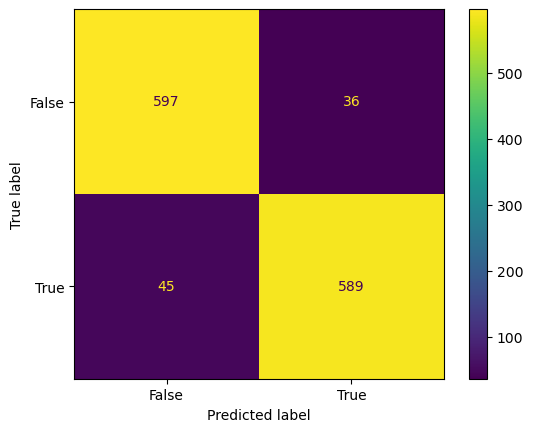

In [46]:
# Confusion matrix of Results from Passive Aggresive classification
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

Model Training : XGBoost

In [94]:
xgb_model = XGBClassifier(
    learning_rate=0.001,         # Step size at each boosting iteration
    n_estimators=1000,           # Number of boosting rounds (trees)
    max_depth=10,                # Maximum depth of each decision tree
    min_child_weight=1,          # Minimum sum of instance weight needed in a child
    subsample=0.8,               # Fraction of samples used for fitting each tree
    colsample_bytree=0.8,        # Fraction of features used for fitting each tree
    objective='binary:logistic', # Objective function for binary classification
    seed=42,                     # Random seed for reproducibility
    gamma=0.01,                  # Minimum loss reduction required to make a further partition
    reg_lambda=0.1               # L2 regularization term on weights
)

xgb_model.fit(tfidf_X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [95]:
# make predictions for test data
Y_pred_xgb = xgb_model.predict(tfidf_X_test)
predictions = [round(value) for value in Y_pred_xgb]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.66%


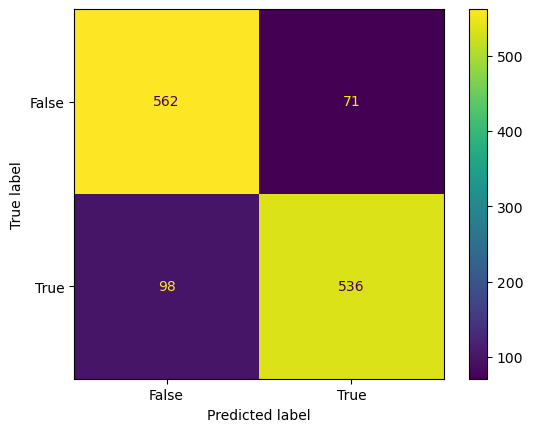

In [96]:
# Confusion matrix of Results from Passive Aggresive classification
cm = metrics.confusion_matrix(Y_test, Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

Evaluation and Prediction

Making a predictive system

In [47]:
def fake_news_detector(news):
    input_data=[news]
    #vectorization
    vectorized_input_data=vectorizer.transform(input_data)
    #predicton
    prediction = classifier.predict(vectorized_input_data)
    # print(prediction)
    if(prediction[0]==0):
        print("Looks like a FAKE News")
    else:
        print("Looks like a REAL News")

Testing on random examples

In [48]:
fake_news_detector("Go to Article President Barack Obama has been campaigning hard for the woman who is supposedly going to extend his legacy four more years. The only problem with stumping for Hillary Clinton, however, is sheâ€™s not exactly a candidate easy to get too enthused about.  """)

Looks like a FAKE News


In [49]:
fake_news_detector('U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sundayâ€™s unity march against terrorism.')

Looks like a REAL News


In [50]:
fake_news_detector("Iranian negotiators reportedly have made a last-ditch push for more concessions from the U.S. and five other world powers as talks on the fate of Iran's nuclear program come down to the final days before a crucial deadline.The New York Times reported late Sunday that Tehran had backed away from a tentative promise to ship a large portion of its uranium stockpile to Russia, where it could not be used as part of any future weapons program. Western officials insisted to the paper that the uranium did not have to be sent overseas, but could be disposed of in other ways.The new twist in the talks comes just two days before the deadline for both sides to agree on a framework for a permanent deal. The final deadline for a permanent deal would not arrive until the end of June.However, if Iran insists on keeping its uranium in the country, it would undermine a key argument made in favor of the deal by the Obama administration. The Times reports that if the uranium had gone to Russia, it would have been converted into fuel rods, which are difficult to use in nuclear weapons. It is not clear what would happen to the uranium if it remained in Iran.The Associated Press reported Sunday that Iran's position had shifted from from demanding that it be allowed to keep nearly 10,000 centrifuges enriching uranium, to agreeing to keep 6,000. Western officials involved in the talks told the Associated Press that Tehran may be ready to accept an even lower number.The United States and its allies want a deal that extends the time Iran would need to make a nuclear weapon from the present two months to three months to at least a year. However, The Times reported Sunday that a paper published by Olli Heinonen, former head of inspections for the U.N.'s nuclear watchdog, estimated that Iran could still develop a nuclear weapon in seven or eight months with around 6,500 centrifuges.Tehran says it wants to enrich uranium only for energy, science, industry and medicine. But many countries fear Iran could use the technology to make weapons-grade uranium.Officials told the Associated Press that another main dispute involved the length of an agreement. Iran, they said, wants a total lifting of all caps on its activities after 10 years, while the U.S. and the five other nations at the talks â€” Russia, China, Britain, France and Germany â€” insist on progressive removal after a decade.A senior U.S. official characterized the issue as lack of agreement on what happens in years 11 to 15. The official spoke on condition of anonymity in line with State Department rules on briefing about the closed-door talks.Limits on Iran's research and development of centrifuges also were unresolved, the Western officials said.Tehran has created a prototype centrifuge that it says enriches uranium 16 times faster than its present mainstay model. The U.S. and its partners want to constrain research that would increase greatly the speed of making enough weapons-grade uranium for a bomb, once limits on Iran's programs are lifted.One official said Russia opposed the U.S. position that any U.N. penalties lifted in the course of a deal should be reimposed quickly if Tehran reneged on any commitments.Both Western officials said Iran was resisting attempts to make inspections and other ways of verification as intrusive as possible.There was tentative agreement on turning a nearly-finished reactor into a model that gives off less plutonium waste than originally envisaged. Plutonium, like enriched uranium, is a path to nuclear weapons.Iran and the U.S. were discussing letting Iran run centrifuges at an underground bunker that has been used to enrich uranium. The machines would produce isotopes for peaceful applications, the officials said.With the Tuesday deadline approaching and problems remaining, U.S. Secretary of State John Kerry canceled plans Sunday to return to the United States for an event honoring the late U.S. Sen. Edward Kennedy. French Foreign Minister Laurent Fabius and Frank-Walter Steinmeier, his German counterpart, scratched planned trips to Kazakhstan.Kerry has been in discussions with Iranian Foreign Minister Mohammad Javad Zarif since Thursday.The Associated Press contributed to this report.Click for more from The New York Times.")

Looks like a REAL News


In [51]:
fake_news_detector("After a week of nonstop criticism from Democrats and Republicans alike for comments many condemned as racially charged, Donald Trump claims to be altering his campaign to be a little more inclusive. While the presumptive G.O.P. has long promised to â€œmake America great again,â€ Trump now says heâ€™s adding two words to slogan to illustrate just how non-racist he really is.â€œYou know, I have the theme â€˜make America great again,â€™ and I've added a couple of things,â€ Trump announced to supporters at a campaign rally in Richmond, Virginia, on Friday night. â€œRight now Iâ€™m adding make America great againâ€”Iâ€™m adding â€˜for everyone,â€™ because itâ€™s really going to be for everyone. Itâ€™s not going to be for a group of people, itâ€™s going to be for everyone. Itâ€™s true.â€The allegedly amended slogan, which has yet to appear on any official signage or Trump merchandise, comes after the presidential candidate spent the first half of June repeatedly denouncing Gonzalo Curiel, the federal judge of Mexican heritage presiding over the Trump University class action lawsuit, as inherently biased against him. (Curiel was born in Indiana.) His comments were widely condemned by the Washington political establishment, including Senate Minority Leader Mitch McConnell, who suggested he may be an idiot, and House Speaker Paul Ryan, who called Trumpâ€™s statement the â€œtextbook definition of a racist comment.â€Trump, who hasnâ€™t apologized or taken back any of his comments, indicated on Friday that he realized his words have had a negative effect on his campaign and declared he is not a racist.â€œI am the least racist person. The least racist person that youâ€™ve ever seen. I mean give me a break,â€ he said at the rally. â€œI am the least racist person that youâ€™ve ever looked at, believe me.â€")

Looks like a REAL News


Pickle and load model
Now, time to pickle (save) the model and vectorizer so you can use them elsewhere.

In [52]:
pickle.dump(classifier, open('models/model.pkl', 'wb'))
pickle.dump(vectorizer, open('models/tfidfvect.pkl', 'wb'))

Let’s see if we can use this model without training again.

In [53]:
model = pickle.load(open('models/model.pkl', 'rb'))
vect = pickle.load(open('models/tfidfvect.pkl', 'rb'))

In [54]:
# Load model and vectorizer

news = "After a week of nonstop criticism from Democrats and Republicans alike for comments many condemned as racially charged, Donald Trump claims to be altering his campaign to be a little more inclusive. While the presumptive G.O.P. has long promised to â€œmake America great again,â€ Trump now says heâ€™s adding two words to slogan to illustrate just how non-racist he really is.â€œYou know, I have the theme â€˜make America great again,â€™ and I've added a couple of things,â€ Trump announced to supporters at a campaign rally in Richmond, Virginia, on Friday night. â€œRight now Iâ€™m adding make America great againâ€”Iâ€™m adding â€˜for everyone,â€™ because itâ€™s really going to be for everyone. Itâ€™s not going to be for a group of people, itâ€™s going to be for everyone. Itâ€™s true.â€The allegedly amended slogan, which has yet to appear on any official signage or Trump merchandise, comes after the presidential candidate spent the first half of June repeatedly denouncing Gonzalo Curiel, the federal judge of Mexican heritage presiding over the Trump University class action lawsuit, as inherently biased against him. (Curiel was born in Indiana.) His comments were widely condemned by the Washington political establishment, including Senate Minority Leader Mitch McConnell, who suggested he may be an idiot, and House Speaker Paul Ryan, who called Trumpâ€™s statement the â€œtextbook definition of a racist comment.â€Trump, who hasnâ€™t apologized or taken back any of his comments, indicated on Friday that he realized his words have had a negative effect on his campaign and declared he is not a racist.â€œI am the least racist person. The least racist person that youâ€™ve ever seen. I mean give me a break,â€ he said at the rally. â€œI am the least racist person that youâ€™ve ever looked at, believe me.â€"

val_pkl = vect.transform([news]).toarray()
pred_pkl=model.predict(val_pkl)
if(pred_pkl[0]==0):
        print("Looks like a FAKE News")
else:
        print("Looks like a REAL News")

Looks like a REAL News


In [55]:
news="Iranian negotiators reportedly have made a last-ditch push for more concessions from the U.S. and five other world powers as talks on the fate of Iran's nuclear program come down to the final days before a crucial deadline.The New York Times reported late Sunday that Tehran had backed away from a tentative promise to ship a large portion of its uranium stockpile to Russia, where it could not be used as part of any future weapons program. Western officials insisted to the paper that the uranium did not have to be sent overseas, but could be disposed of in other ways.The new twist in the talks comes just two days before the deadline for both sides to agree on a framework for a permanent deal. The final deadline for a permanent deal would not arrive until the end of June.However, if Iran insists on keeping its uranium in the country, it would undermine a key argument made in favor of the deal by the Obama administration. The Times reports that if the uranium had gone to Russia, it would have been converted into fuel rods, which are difficult to use in nuclear weapons. It is not clear what would happen to the uranium if it remained in Iran.The Associated Press reported Sunday that Iran's position had shifted from from demanding that it be allowed to keep nearly 10,000 centrifuges enriching uranium, to agreeing to keep 6,000. Western officials involved in the talks told the Associated Press that Tehran may be ready to accept an even lower number.The United States and its allies want a deal that extends the time Iran would need to make a nuclear weapon from the present two months to three months to at least a year. However, The Times reported Sunday that a paper published by Olli Heinonen, former head of inspections for the U.N.'s nuclear watchdog, estimated that Iran could still develop a nuclear weapon in seven or eight months with around 6,500 centrifuges.Tehran says it wants to enrich uranium only for energy, science, industry and medicine. But many countries fear Iran could use the technology to make weapons-grade uranium.Officials told the Associated Press that another main dispute involved the length of an agreement. Iran, they said, wants a total lifting of all caps on its activities after 10 years, while the U.S. and the five other nations at the talks â€” Russia, China, Britain, France and Germany â€” insist on progressive removal after a decade.A senior U.S. official characterized the issue as lack of agreement on what happens in years 11 to 15. The official spoke on condition of anonymity in line with State Department rules on briefing about the closed-door talks.Limits on Iran's research and development of centrifuges also were unresolved, the Western officials said.Tehran has created a prototype centrifuge that it says enriches uranium 16 times faster than its present mainstay model. The U.S. and its partners want to constrain research that would increase greatly the speed of making enough weapons-grade uranium for a bomb, once limits on Iran's programs are lifted.One official said Russia opposed the U.S. position that any U.N. penalties lifted in the course of a deal should be reimposed quickly if Tehran reneged on any commitments.Both Western officials said Iran was resisting attempts to make inspections and other ways of verification as intrusive as possible.There was tentative agreement on turning a nearly-finished reactor into a model that gives off less plutonium waste than originally envisaged. Plutonium, like enriched uranium, is a path to nuclear weapons.Iran and the U.S. were discussing letting Iran run centrifuges at an underground bunker that has been used to enrich uranium. The machines would produce isotopes for peaceful applications, the officials said.With the Tuesday deadline approaching and problems remaining, U.S. Secretary of State John Kerry canceled plans Sunday to return to the United States for an event honoring the late U.S. Sen. Edward Kennedy. French Foreign Minister Laurent Fabius and Frank-Walter Steinmeier, his German counterpart, scratched planned trips to Kazakhstan.Kerry has been in discussions with Iranian Foreign Minister Mohammad Javad Zarif since Thursday.The Associated Press contributed to this report.Click for more from The New York Times."
val_pkl = vect.transform([news]).toarray()
pred_pkl=model.predict(val_pkl)
if(pred_pkl[0]==0):
        print("Looks like a FAKE News")
else:
        print("Looks like a REAL News")

Looks like a REAL News


In [56]:
news="President Obama's supporters sometimes wonder where the inspirational candidate of 2008 has gone. The answer is to the White House. Obama's presidency is about smaller, less inspiring questions than his 2008 campaigObama's presidency is bounded by the limits of the office and the demands of the moment. It is about what America needs to do right now â€” the next budget, the next bill, next year's taxes, the last war. Candidates can muse. Presidents must goverObama's 2008 campaign was about what kind of country America is; how to read its past to best guide its future. His speech in Selma â€” which is reallyÂ worth reading in its entirety â€” was among the best of his presidency precisely because it had almost nothing to do with his presidency; it was a return to the central topic of his campaigHistorians who want to understand Obama will find few better summations than the two paragraphs at the core of this speecWe do a disservice to the cause of justice by intimating that bias and discrimination are immutable, or that racial division is inherent to America. If you think nothing's changed in the past fifty years, ask somebody who lived through the Selma or Chicago or L.A. of the Fifties. Ask the female CEO who once might have been assigned to the secretarial pool if nothing's changed. Ask your gay friend if it's easier to be out and proud in America now than it was thirty years ago. To deny this progress â€” our progress â€” would be to rob us of our own agency; our responsibility to do what we can to make America better. Of course, a more common mistake is to suggest that racism is banished, that the work that drew men and women to Selma is complete, and that whatever racial tensions remain are a consequence of those seeking to play the 'race card' for their own purposes. We don't need the Ferguson report to know that's not true. We just need to open our eyes, and ears, and hearts, to know that this nation's racial history still casts its long shadow upon us. We know the march is not yet over, the race is not yet won, and that reaching that blessed destination where we are judged by the content of our character requires admitting as mucThose 230 words are a precise distillation of Obama's view of America, and the role politics must play in it.The first paragraph is Obama's case for hope: America is improving; it has always been improving, and to deny that improvement is to steal from Americans a belief in their country that they have more than earned. 'To deny this progress â€' our progress â€' would be to rob us of our own agency,'he said.The second paragraph is Obama's case for change: America's sins are not vanquished; its hatreds remain real; its racism still breathes. 'We know the march is not yet over,' Obama said, 'the race is not yet won, and that reaching that blessed destination where we are judged by the content of our character requires admitting as much.'Hope and change. These are the two ideas that form the steady core of Obama's politics. But, more than that, they are the two ideas that define, for Obama, what kind of country America is â€” and what it means to serve it.Obama's critics question his love for the country he governs. 'I do not believe â€' and I know this is a horrible thing to say â€' but I do not believe that the president loves America,' former New York Mayor Rudy Giuliani said in February. They look at Obama's steady belief that America is not yet good enough, not yet pure enough, not yet perfect enough, and they see a skeptic, not a patriot.In this speech, Obama's answer to this criticism was direct:Fellow marchers, so much has changed in fifty years. We've endured war, and fashioned peace. We've seen technological wonders that touch every aspect of our lives, and take for granted convenience our parents might scarcely imagine. But what has not changed is the imperative of citizenship, that willingness of a 26 year-old deacon, or a Unitarian minister, or a young mother of five, to decide they loved this country so much that they'd risk everything to realize its promise. That's what it means to love America. That's what it means to believe in America. That's what it means when we say America is exceptional.There is an implicit radicalism in what Obama is saying here.Â To believe America is good enough is to abandon the tradition of criticism and activism that has made America great.Obama's answer to Giuliani is that Giuliani has mistaken uncritical adoration for the hard work required of true love. Patriotism is active, not passive. Those who love America prove it by working to perfect America. They continue marching."
val_pkl = vect.transform([news]).toarray()
pred_pkl=model.predict(val_pkl)
if(pred_pkl[0]==0):
        print("Looks like a FAKE News")
else:
        print("Looks like a REAL News")

Looks like a REAL News


In [ ]:
import tkinter as tk
from tkinter import *
from newspaper import Article, ArticleException
# GUI Window
top = tk.Tk()
top.geometry('680x500')
top.title('News Article Summary')

# Frame for the URL entry
url_frame = Frame(top, bg='white')
url_frame.pack(pady=20)

# Label for URL
url_label = Label(url_frame, text="URL:", font=('arial', 14, 'bold'), bg='white')
url_label.pack(side='left')

# Entry field for URL
news_url = Entry(url_frame, width=60, borderwidth=2, font=('verdana', 12))
news_url.pack(side='left', padx=10)

        
# Function to handle the detection button click
def detect_news_authenticity_wrapper():
    url = news_url.get()
    if url:
        result, summary = detect_news_authenticity(url)
        display_detection_result(result, summary)
        if result:
            summary_label.config(text=summary)  # Update the summary_label with the obtained summary
    else:
        detection_result_label.config(text="Please enter a valid URL or Article")
        
# Button for detecting and summarizing news
detect_button = Button(url_frame, text="Detect and Summarize", font=('verdana', 12, 'bold'), command=detect_news_authenticity_wrapper)
detect_button.pack(side='left', padx=10)

# Frame for displaying detection result
detection_frame = Frame(top, bg="white", padx=10, pady=10)
detection_frame.pack(fill="x", pady=10)

# Title for detection space
detection_title_label = Label(detection_frame, text="Detection Result", font=('arial', 16, 'bold'), bg="white")
detection_title_label.pack()

# Label for displaying the detection result
detection_result_label = Label(detection_frame, text="", font=('arial', 14), fg='red', bg="white")
detection_result_label.pack(pady=5)

# Frame for displaying summary
summary_frame = Frame(top, bg="white", padx=10, pady=10)
summary_frame.pack(fill="both", expand=True)

# Title for summary space
summary_title_label = Label(summary_frame, text="Summary", font=('arial', 16, 'bold'), bg="white")
summary_title_label.pack()

# Label for displaying the summary
summary_label = Label(summary_frame, text="", font=('verdana', 12), wraplength=600, justify=LEFT, bg="white")
summary_label.pack(pady=5)


    # Define the function
def detect_news_authenticity(input_data):
    if input_data.startswith("http"):
        # Input is a URL
        article = Article(input_data)
        article.download()
        article.parse()
        if article.text:
            article.nlp()
            news = article.text
            print(news)
        else:
            print("Failed to extract article content. Please check the URL.")
            return
    else:
        # Input is text
        news = input_data

    # Use the pre-trained vectorizer and model
    val_pkl = vect.transform([news]).toarray()
    pred_pkl = model.predict(val_pkl)
    if pred_pkl[0] == 0:
            return False, ""  # Fake News

    else:
            summary = article.summary
            ## print("Summary:", summary)  # Print the summary
            return True, summary  # True News   

    
# Function to display detection result
def display_detection_result(result, summary):
    if result:
        detection_result_label.config(text="True News Detected!", fg='green')
        summary_label.config(text="Summary: " + summary)  # Set the text of summary_label
        summary_label.pack(pady=5)  # Pack summary_label
    else:
        detection_result_label.config(text="Fake News Detected!", fg='red')
        summary_label.config(text="")  # Clear any existing text
        summary_label.pack_forget()  # Remove summary_label from the GUI







top.mainloop()

Thai authorities issued an extreme heat warning for Bangkok on Wednesday, urging people to stay indoors for their own safety as temperatures soared. Thai authorities issued an extreme heat warning for Bangkok on Wednesday, urging people to stay indoors for their own safety as temperatures soared.(AFP)

The mercury was forecast to hit 39C in the sprawling Thai capital, while the heat index rose above 52C, classed as "extremely dangerous" by city authorities.

HT launches Crick-it, a one stop destination to catch Cricket, anytime, anywhere. Explore now!

The heat index is a measure of what the temperature feels like, taking humidity, wind speed and other factors into account.

"Warning: the heat index today is 'extremely dangerous'. Please avoid activities outdoors," the Bangkok city authority's environment department wrote in a Facebook post.

"The heat index is classed as extremely dangerous when it goes above 52 degrees Celsius."

ALSO READ| About 1,300 people flee Myanmar to Thailand

Iran has announced the death sentence to Toomaj Salehi, a prominent hip-hop artist, for his involvement in widespread unrest during 2022-23, his lawyer told newspaper Sharq.

Salehi, 33, backed the months-long protests in support of Mahsa Amini, a 22-year-old Kurdish Iranian woman who died in police custody after being arrested for wearing an "improper" hijab.

Salehi's initial arrest in October 2022 came after he publicly expressed solidarity with the nationwide demonstrations. He articulated his support through rap compositions and shared images and videos online, earning accolades from Western media as the "world’s bravest rapper."

In 2023, he was sentenced to six years and three months in prison, narrowly avoiding a death sentence after a Supreme Court ruling. His case was sent back to court for re-evaluation. Subsequently, the musician was confronted with new charges following a video in which he discussed being tortured while incarcerated.

His lawyer, Amir Raisian, told Sharq t

Trump has made presidential immunity claims in two other criminal cases (File)

The US Supreme Court hears arguments on Thursday on Donald Trump's claim that he enjoys sweeping immunity from criminal prosecution for actions he took as president, a claim that has delayed by months a case accusing him of trying to overturn his 2020 defeat.

Here is a look at why Trump's claims have delayed a trial and what is likely to happen next:

Why has the immunity appeal delayed the election subvrsion case?

The federal case brought by Special Counsel Jack Smith charging Trump with trying to overturn his election defeat -- one of four criminal cases the Republican presidential candidate faces -- has been paused since December while the immunity argument plays out.

Criminal defendants are not usually able to appeal court rulings until after a trial if they are convicted, but Trump was able to file an immediate appeal because the immunity argument bears on whether he must even face a trial.

US Dist

Near-daily exchanges of fire continue to rage on the border between the two countries. (Representational)

The Israeli army said Wednesday it struck 40 Hezbollah targets in southern Lebanon as near-daily exchanges of fire rage on the border between the two countries.

"A short while ago, IDF (army) fighter jets and artillery struck approximately 40 Hezbollah terror targets" around Aita al-Shaab in southern Lebanon, including storage facilities and weaponry, the army said in a statement.

(Except for the headline, this story has not been edited by NDTV staff and is published from a syndicated feed.)


In [58]:
detect_news_authenticity("https://www.hindustantimes.com/world-news/iranisrael-conflict-live-hamas-war-gaza-strip-airstrikes-drones-hezbollah-attack-latest-updates-today-april-14-101713053165142.html")


Welcome to our live coverage of the escalating tensions between Iran and Israel, which threaten to plunge the region into a deeper crisis. The situation has taken a dramatic turn as Iran launched an unprecedented drone and missile attack on Israel, marking a significant escalation in the long-running covert war between the two regional foes....Read More

As reports of air raid sirens emerge from various locations, including northern and southern Israel, the northern West Bank, and the Dead Sea near the Jordanian border, the extent of the damage remains unclear. The Israeli military said it working with the United States and other partners in the region in order to act against the launches and intercept them. U.S. forces reportedly downed some of the Iran-launched drones flying toward Israel.

Global outcry over Iran's attack on Israel sparks diplomatic frenzy. Who said what

With tensions already at a boiling point, the Iranian Revolutionary Guards confirmed their role in the retaliato

(True,
 "Welcome to our live coverage of the escalating tensions between Iran and Israel, which threaten to plunge the region into a deeper crisis.\nThe Israeli military said it working with the United States and other partners in the region in order to act against the launches and intercept them.\nU.S. forces reportedly downed some of the Iran-launched drones flying toward Israel.\nGlobal outcry over Iran's attack on Israel sparks diplomatic frenzy.\nIn this live blog, we aim to provide you with minute-by-minute updates on the evolving situation, offering detailed analysis, expert commentary, and insights into the geopolitical dynamics at play.")

In [63]:
detect_news_authenticity("Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed â€œno debate so far as I could ascertain as to who their spokesman was to beâ€ (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). â€œI am very glad that Miss Adams made it clear that what I am speaking for today is all of us â€”  the 400 of us,â€ Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mortimer Snerds in attendance, the    bespectacled in granny glasses (awarding her matronly wisdom â€”  or at least John Lennon wisdom) took issue with the previous speaker. Despite becoming the first   to win election to a seat in the U. S. Senate since Reconstruction, Edward Brooke came in for criticism for calling for â€œempathyâ€ for the goals of protestors as he criticized tactics. Though Clinton in her senior thesis on Saul Alinsky lamented â€œBlack Power demagoguesâ€ and â€œelitist arrogance and repressive intoleranceâ€ within the New Left, similar words coming out of a Republican necessitated a brief rebuttal. â€œTrust,â€ Rodham ironically observed in 1969, â€œthis is one word that when I asked the class at our rehearsal what it was they wanted me to say for them, everyone came up to me and said â€˜Talk about trust, talk about the lack of trust both for us and the way we feel about others. Talk about the trust bust.â€™ What can you say about it? What can you say about a feeling that permeates a generation and that perhaps is not even understood by those who are distrusted?â€ The â€œtrust bustâ€ certainly busted Clintonâ€™s 2016 plans. She certainly did not even understand that people distrusted her. After Whitewater, Travelgate, the vast   conspiracy, Benghazi, and the missing emails, Clinton found herself the distrusted voice on Friday. There was a load of compromising on the road to the broadening of her political horizons. And distrust from the American people â€”  Trump edged her 48 percent to 38 percent on the question immediately prior to Novemberâ€™s election â€”  stood as a major reason for the closing of those horizons. Clinton described her vanquisher and his supporters as embracing a â€œlie,â€ a â€œcon,â€ â€œalternative facts,â€ and â€œa   assault on truth and reason. â€ She failed to explain why the American people chose his lies over her truth. â€œAs the history majors among you here today know all too well, when people in power invent their own facts and attack those who question them, it can mark the beginning of the end of a free society,â€ she offered. â€œThat is not hyperbole. â€ Like so many people to emerge from the 1960s, Hillary Clinton embarked upon a long, strange trip. From high school Goldwater Girl and Wellesley College Republican president to Democratic politician, Clinton drank in the times and the place that gave her a degree. More significantly, she went from idealist to cynic, as a comparison of her two Wellesley commencement addresses show. Way back when, she lamented that â€œfor too long our leaders have viewed politics as the art of the possible, and the challenge now is to practice politics as the art of making what appears to be impossible possible. â€ Now, as the big woman on campus but the odd woman out of the White House, she wonders how her current station is even possible. â€œWhy arenâ€™t I 50 points ahead?â€ she asked in September. In May she asks why she isnâ€™t president. The woman famously dubbed a â€œcongenital liarâ€ by Bill Safire concludes that lies did her in â€”  theirs, mind you, not hers. Getting stood up on Election Day, like finding yourself the jilted bride on your wedding day, inspires dangerous delusions.")

Looks like a FAKE News
